# Figure 1 - CNN model predicability of itself and across datasets
-----

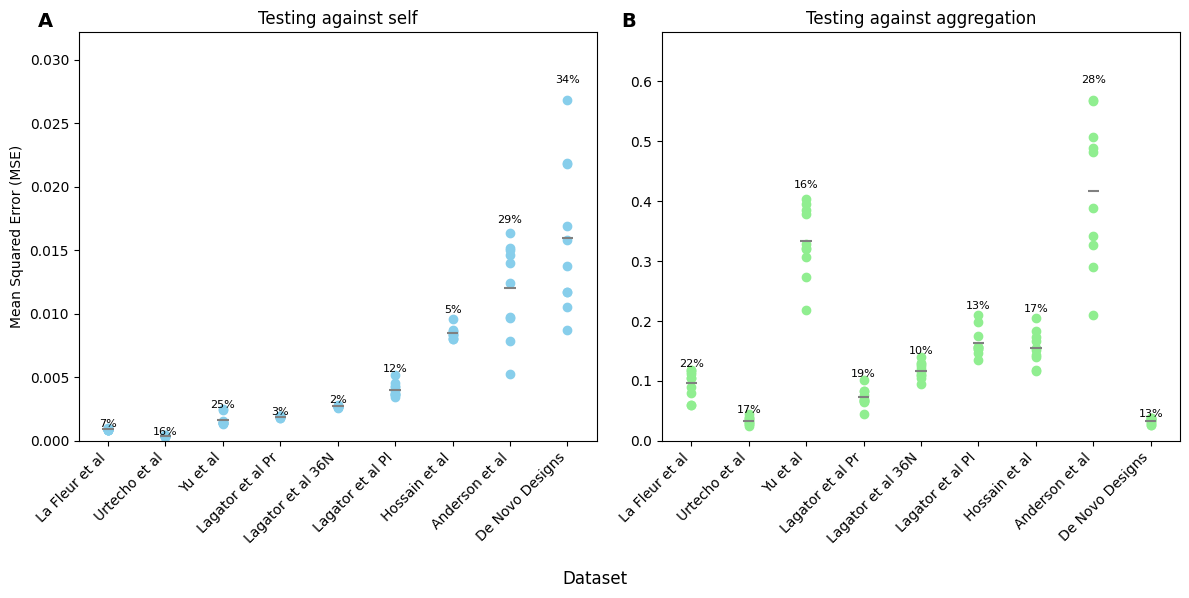

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# -------------------- Data Preprocessing Functions --------------------

def combine_columns(df):
    X = df['Promoter Sequence'].astype(str)
    y = df['Normalized Observed log(TX/Txref)']
    return X, y

def padded_one_hot_encode(seq):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    return [mapping[n.upper()] for n in seq]

def preprocess_sequences(X, max_length=150):
    return np.array([padded_one_hot_encode(seq.zfill(max_length)) for seq in X])

# -------------------- Data Splitting Function --------------------

def split_data_by_file(df):
    file_names = df['File Name'].unique()
    split_data = {name: {} for name in file_names}
    split_data['all'] = {}

    for name in list(file_names) + ['all']:
        subset = df if name == 'all' else df[df['File Name'] == name]
        X, y = combine_columns(subset)
        X = preprocess_sequences(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        split_data[name].update({'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test})

    return split_data, file_names

# -------------------- Load Evaluation Metrics --------------------

def load_repeat_evaluate(csv_path):
    df = pd.read_csv(csv_path, index_col=0)
    results = {}
    for col in df.columns:
        if ' (Self)' in col:
            key = col.replace(' (Self)', '')
            results[key] = list(zip(df[f'{key} (Self)'], df[f'{key} (All)']))
    return results

# -------------------- Main Execution --------------------

df = pd.read_csv('Data/LaFleur_supp.csv')
split_data, file_names = split_data_by_file(df)
all_results = load_repeat_evaluate('Data/repeat_evalute_each_file.csv')

file_order = [
    'La Fleur et al', 'Urtecho et al', 'Yu et al', 'Lagator et al Pr',
    'Lagator et al 36N', 'Lagator et al Pl', 'Hossain et al',
    'Anderson et al', 'De Novo Designs'
]
file_order = [f for f in file_order if f in file_names]
x = np.arange(len(file_order))

# Calculate averages and coefficient of variation (CV)
avg_results = {f: np.mean(all_results[f], axis=0) for f in file_names}
avg_train = {f: res[0] for f, res in avg_results.items()}
avg_all = {f: res[1] for f, res in avg_results.items()}

cv_train = {f: np.std([r[0] for r in all_results[f]]) / avg_train[f] for f in file_names}
cv_all = {f: np.std([r[1] for r in all_results[f]]) / avg_all[f] for f in file_names}

# Extract MSEs
train_mse = {f: [r[0] for r in all_results[f]] for f in file_order}
all_mse = {f: [r[1] for r in all_results[f]] for f in file_order}
avg_train_list = [avg_train[f] for f in file_order]
avg_all_list = [avg_all[f] for f in file_order]

# -------------------- Plotting --------------------

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for i, file in enumerate(file_order):
    ax1.scatter([x[i]] * len(train_mse[file]), train_mse[file], color='skyblue')
    ax1.hlines(avg_train_list[i], x[i] - 0.1, x[i] + 0.1, colors='grey')
    ax1.text(x[i], max(train_mse[file]) * 1.05, f'{int(cv_train[file]*100)}%', ha='center', fontsize=8)

ax1.set_xticks(x, file_order, rotation=45, ha='right')
ax1.set_ylabel('Mean Squared Error (MSE)')
ax1.set_title('Testing against self')
ax1.set_ylim(0, max(map(max, train_mse.values())) * 1.2)

ax1.text(-0.05, 1.05, "A", transform=ax1.transAxes, ha='right', va='top', fontsize=14, fontweight='bold')

for i, file in enumerate(file_order):
    ax2.scatter([x[i]] * len(all_mse[file]), all_mse[file], color='lightgreen')
    ax2.hlines(avg_all_list[i], x[i] - 0.1, x[i] + 0.1, colors='grey')
    ax2.text(x[i], max(all_mse[file]) * 1.05, f'{int(cv_all[file]*100)}%', ha='center', fontsize=8)

ax2.set_xticks(x, file_order, rotation=45, ha='right')
ax2.set_title('Testing against aggregation')
ax2.set_ylim(0, max(map(max, all_mse.values())) * 1.2)

ax2.text(-0.05, 1.05, "B", transform=ax2.transAxes, ha='right', va='top', fontsize=14, fontweight='bold')

fig.supxlabel("Dataset")
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig('Figures/Figure1.pdf', dpi=300, bbox_inches='tight')

# Figure 2 - CNN construction integrating multiple datasets
-----

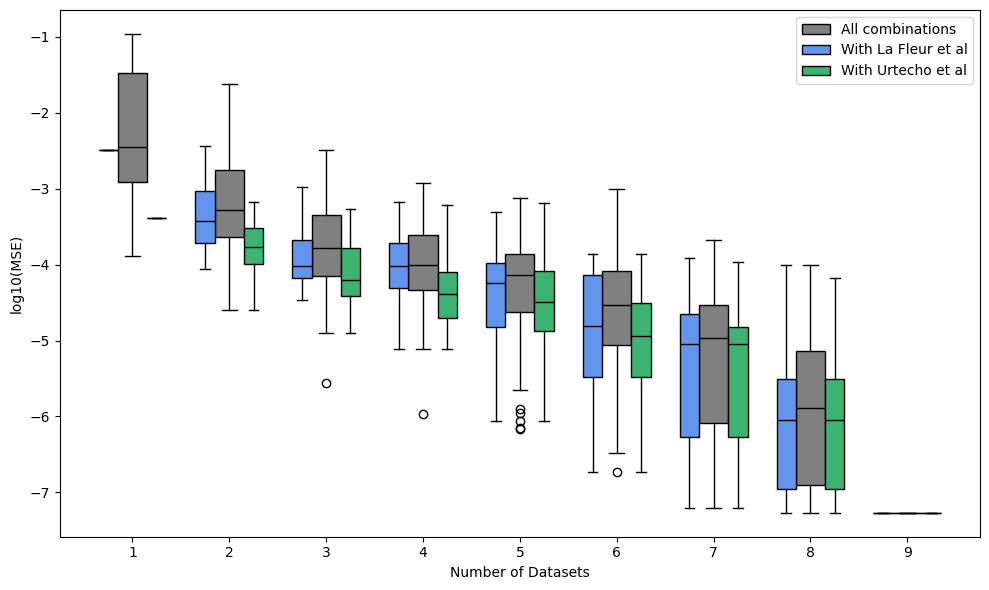

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load file names
file_names = pd.read_csv('Data/LaFleur_supp.csv')['File Name'].unique()
target_includes = ['La Fleur et al', 'Urtecho et al']
file_names = [f for f in file_names if f in target_includes]

data_df = pd.read_csv('Data/data_comparison.csv')
data = data_df[['Number of Files', 'MSE', 'Name']].values

fig, ax = plt.subplots(figsize=(10, 6))

colors = {
    'La Fleur et al': 'cornflowerblue',
    'Urtecho et al': 'mediumseagreen'
}

x_all = sorted(set(int(n) for n, _, _ in data))

# Scatter plot
##scatter_data = [(int(n), l) for n, l, _ in data]
##x_vals, y_vals = zip(*scatter_data)
##ax.scatter(x_vals, y_vals, s=100, alpha=0.2, color='grey')

# Boxplots
labeled=True
for x in x_all:
    y_vals = [l for n, l, combo in data if int(n) == x]
    ax.boxplot([y_vals], positions=[x], widths=0.3, patch_artist=True,
                   boxprops=dict(facecolor='grey'),
                   medianprops=dict(color='black'), 
                   label="All combinations" if labeled else None)
    labeled=False
    for i, file_name in enumerate(target_includes):
        y_vals = [l for n, l, combo in data if int(n) == x and file_name in str(combo)]
        if not y_vals:
            continue

        # Offset x slightly for visual separation
        offset = -0.25 if i == 0 else 0.25
        ax.boxplot([y_vals], positions=[x + offset], widths=0.2, patch_artist=True,
                   boxprops=dict(facecolor=colors[file_name]), showfliers=False,
                   medianprops=dict(color='black'),
                   label=f"With {file_name}" if x == x_all[0] else None)

ax.set_xticks(x_all)
ax.set_xticklabels(x_all)

ax.set_xlabel('Number of Datasets')
ax.set_ylabel('log10(MSE)')
ax.legend()

plt.tight_layout()
plt.show()

# Save the figure
fig.savefig('Figures/Figure2.pdf', dpi=300, bbox_inches='tight')


# Figure 3 - Comparison of Heuristic and Hyperparameter Model

-----

 33/305 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


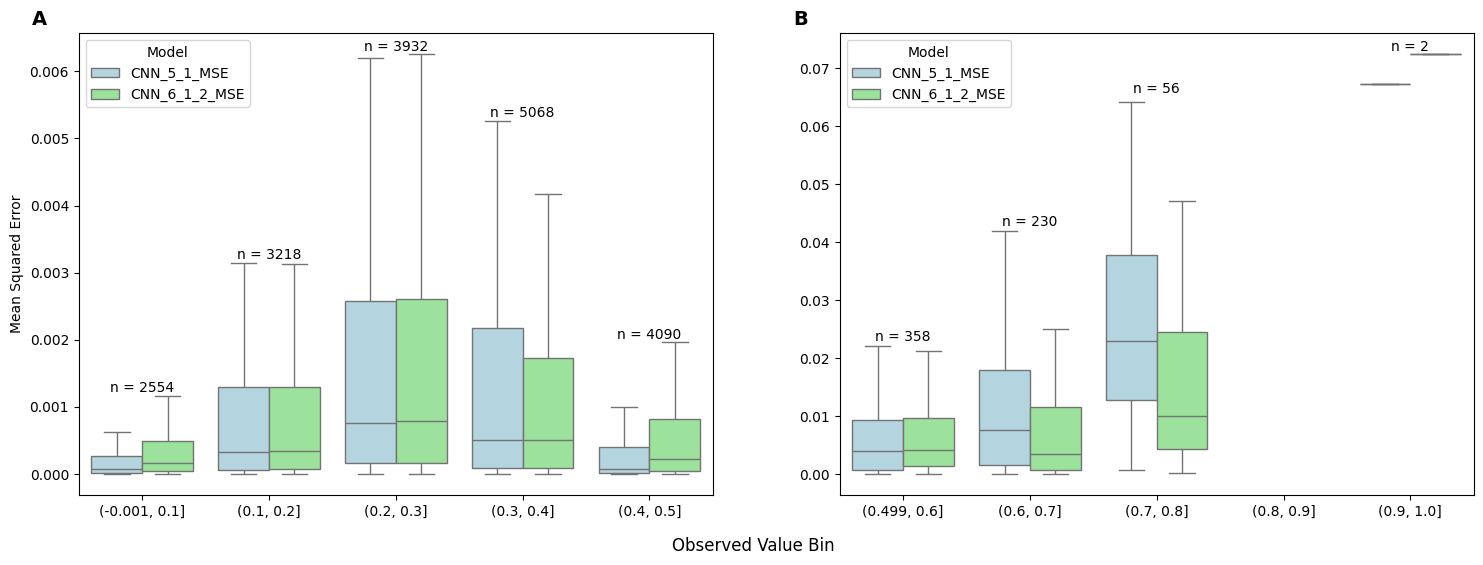

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model  # type: ignore

# -------------------- Data Preprocessing Functions --------------------

def combine_columns(df):
    X = df['Promoter Sequence'].astype(str)
    y = MinMaxScaler().fit_transform(df[['Observed log(TX/Txref)']].abs())
    return X, y

def padded_one_hot_encode(seq):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    return [mapping[n.upper()] for n in seq]

def preprocess_sequences(X, max_length=150):
    return np.array([padded_one_hot_encode(seq.zfill(max_length)) for seq in X])

# -------------------- Load and Preprocess Data --------------------

df = pd.read_csv('Data/LaFleur_supp.csv')
x, y = combine_columns(df)
X = preprocess_sequences(x)
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

CNN_5_1 = load_model('Models/CNN_5_1.keras')
CNN_6_1_2 = load_model('Models/CNN_6_1_2.keras')

df = pd.DataFrame({
    'Observed': y_test.flatten(),
    'CNN_5_1_pred': CNN_5_1.predict(X_test).flatten(),
    'CNN_6_1_2_pred': CNN_6_1_2.predict(X_test).flatten(),
})

df['CNN_5_1_MSE'] = (df['Observed'] - df['CNN_5_1_pred']) ** 2
df['CNN_6_1_2_MSE'] = (df['Observed'] - df['CNN_6_1_2_pred']) ** 2

# -------------------- Plotting MSE Distributions --------------------

bins_low = np.linspace(0, 0.5, 6)
bins_high = np.linspace(0.5, 1, 6)
df['Observed_bin_low'] = pd.cut(df['Observed'], bins_low, include_lowest=True)
df['Observed_bin_high'] = pd.cut(df['Observed'], bins_high, include_lowest=True)

mse_columns = ['CNN_5_1_MSE', 'CNN_6_1_2_MSE']
mse_data_low = pd.melt(
    df,
    id_vars=['Observed_bin_low'],
    value_vars=mse_columns,
    var_name='Model',
    value_name='MSE'
)
mse_data_high = pd.melt(
    df,
    id_vars=['Observed_bin_high'],
    value_vars=mse_columns,
    var_name='Model',
    value_name='MSE'
)

# -------------------- Plotting MSE Distributions as Subplots --------------------

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Count number of samples per bin
counts_low = mse_data_low.groupby('Observed_bin_low', observed=False).size()
counts_high = mse_data_high.groupby('Observed_bin_high', observed=False).size()

# Plot for observed bins < 0.5
sns.boxplot(
    x='Observed_bin_low',
    y='MSE',
    hue='Model',
    data=mse_data_low,
    palette=['lightblue', 'lightgreen'],
    showfliers=False,
    ax=axes[0],
)
axes[0].set_xlabel('')
axes[0].set_ylabel('Mean Squared Error')

# Compute Q3 + 1.5*IQR (upper whisker)
q3_iqr_low = mse_data_low.groupby(['Observed_bin_low', 'Model'], observed=True)['MSE'].agg(
    q3=lambda x: x.quantile(0.75),
    iqr=lambda x: x.quantile(0.75) - x.quantile(0.25)
).reset_index()
q3_iqr_low['upper_whisker'] = q3_iqr_low['q3'] + 1.5 * q3_iqr_low['iqr']
max_whiskers_low = q3_iqr_low.groupby('Observed_bin_low', observed=False)['upper_whisker'].max()

# Annotate above whisker
for i, (bin_label, count) in enumerate(counts_low.items()):
    whisker_top = max_whiskers_low.get(bin_label, 0)
    axes[0].text(i, whisker_top, f'n = {count}', ha='center', va='bottom', fontsize=10)

# Plot for observed bins > 0.5
sns.boxplot(
    x='Observed_bin_high',
    y='MSE',
    hue='Model',
    data=mse_data_high,
    palette=['lightblue', 'lightgreen'],
    showfliers=False,
    ax=axes[1],
)
axes[1].set_xlabel('')
axes[1].set_ylabel('')

q3_iqr_high = mse_data_high.groupby(['Observed_bin_high', 'Model'], observed=True)['MSE'].agg(
    q3=lambda x: x.quantile(0.75),
    iqr=lambda x: x.quantile(0.75) - x.quantile(0.25)
).reset_index()
q3_iqr_high['upper_whisker'] = q3_iqr_high['q3'] + 1.5 * q3_iqr_high['iqr']
max_whiskers_high = q3_iqr_high.groupby('Observed_bin_high', observed=False)['upper_whisker'].max()

for i, (bin_label, count) in enumerate(counts_high.items()):
    whisker_top = max_whiskers_high.get(bin_label, np.nan)
    if np.isfinite(whisker_top):
        offset = -0.01 if i == 2 else 0
        axes[1].text(i, whisker_top + offset, f'n = {count}', ha='center', va='bottom', fontsize=10)

fig.supxlabel('Observed Value Bin')

axes[0].text(-0.05, 1.05, "A", transform=axes[0].transAxes, ha='right', va='top', fontsize=14, fontweight='bold')
axes[1].text(-0.05, 1.05, "B", transform=axes[1].transAxes, ha='right', va='top', fontsize=14, fontweight='bold')

plt.savefig('Figures/Figure3.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Figure 4 - Expression normalized Saliency Map of datasets

--------

## Table1- Summary of datasets for CNN model training


In [41]:
import pandas as pd

df = pd.read_csv('Data/CNN_file_metrics.csv')[['File Name','Sequence Count','Within-File Entropy', 'Within-File Hamming Distance', 'Training Data CV','All Data CV']]
df.rename(columns={'File Name' : 'Dataset', 'Sequence Count': 'Dataset Size',
				   'Training Data CV': 'Coefficient of Variation (Self)','All Data CV': 'Coefficient of Variation (Aggregated)'}, inplace=True)

df.to_csv('Figures/TableS1.csv', index=False)
df.head(None)

,Dataset,Dataset Size,Within-File Entropy,Within-File Hamming Distance,Coefficient of Variation (Self),Coefficient of Variation (Aggregated)
0,La Fleur et al,5391,0.732649,25.173317,0.072744,0.227085
1,Urtecho et al,10898,1.513936,86.719749,0.164779,0.172279
2,Yu et al,1493,0.352242,21.625176,0.258020,0.167959
3,Lagator et al Pr,12194,0.375852,16.272864,0.039902,0.196077
4,Lagator et al 36N,11485,0.614703,26.777638,0.026652,0.108187
5,Lagator et al Pl,2903,0.419147,19.612462,0.122361,0.137066
6,Hossain et al,4350,1.799955,52.386382,0.053693,0.170077
7,Anderson et al,18,0.205827,3.580952,0.290574,0.280333
8,De Novo Designs,35,1.217053,60.679089,0.349975,0.131731


# Supplementary Figures

## Figure S1 - Dataset size versus Average MSE and Variations in MSE with Sequence Diversity
-----

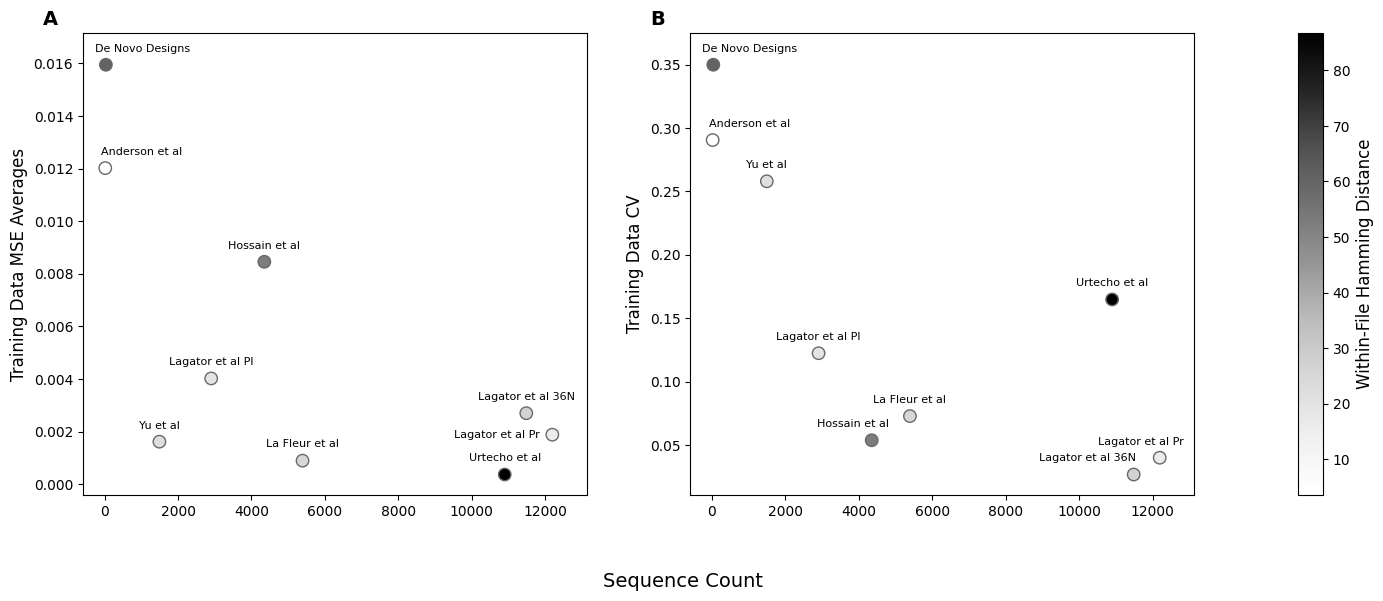

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm, colors as mcolors

def adjust_text_pos(idx, x, y, y_offset, label):
    custom_offsets = {
        ('De Novo Designs', None): (1000, 0),
        ('Anderson et al', None): (1000, 0),
        ('Lagator et al Pr', 0): (-1500, -y_offset * 1.5),
        ('Lagator et al Pr', 1): (-500, 0),
        ('Hossain et al', 1): (-500, 0),
        ('Lagator et al 36N', 1): (-1250, 0),
    }
    dx, dy = custom_offsets.get((label, idx)) or custom_offsets.get((label, None), (0, 0))
    return x + dx, y + dy

# Load data
df = pd.read_csv('Data/CNN_file_metrics.csv')

# Setup figure and axes
fig = plt.figure(figsize=(16, 6))
gs = GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.3)
axes = [fig.add_subplot(gs[0, i]) for i in range(2)]

# Setup colormap normalization
color_col = 'Within-File Hamming Distance'
norm = mcolors.Normalize(vmin=df[color_col].min(), vmax=df[color_col].max())
cmap = cm.Greys

x_col = 'Sequence Count'
y_cols = ['Training Data MSE Averages', 'Training Data CV']

# Plot scatter plots
for idx, (ax, y_col) in enumerate(zip(axes, y_cols)):
    scatter = ax.scatter(
        df[x_col],
        df[y_col],
        c=df[color_col],
        cmap=cmap,
        edgecolor='dimgrey',
        s=80
    )

    # Adjust text annotations
    x_offset = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.025
    y_offset = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.025

    for _, row in df.iterrows():
        x, y = row[x_col], row[y_col] + y_offset
        label = row['File Name']
        adj_x, adj_y = adjust_text_pos(idx, x, y, y_offset, label)
        ax.text(adj_x, adj_y, label, fontsize=8, ha='center', va='bottom')

    ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + x_offset)
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + y_offset)
    ax.set_ylabel(y_col, fontsize=12)
    ax.text(-0.05, 1.05, chr(65 + idx), transform=ax.transAxes,
            ha='right', va='top', fontsize=14, fontweight='bold')

cbar_ax = fig.add_subplot(gs[0, 2])
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax).set_label(color_col, fontsize=12)
fig.supxlabel(x_col, fontsize=14, y=-0.05)

# Show and save figure
plt.show()
fig.savefig('Figures/FigureS1.pdf', dpi=300, bbox_inches='tight')


## Figure S1 C- Transformed Expression distributions for each dataset

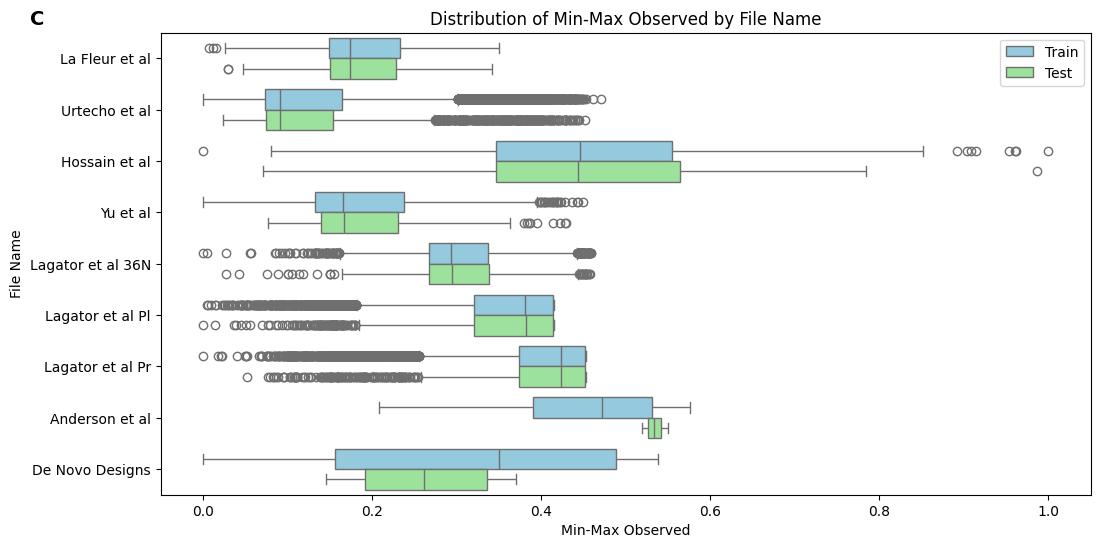

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load and process data
df = pd.read_csv('Data/LaFleur_supp.csv')
df['Min-Max Observed'] = MinMaxScaler().fit_transform(df[['Observed log(TX/Txref)']].abs())

# Split into train/test
indices = np.arange(len(df))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
df['Split'] = 'Train'
df.loc[test_idx, 'Split'] = 'Test'

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Min-Max Observed', y='File Name', hue='Split', palette={'Train': 'skyblue', 'Test': 'lightgreen'})

plt.title('Distribution of Min-Max Observed by File Name')
plt.xlabel('Min-Max Observed')
plt.ylabel('File Name')
plt.legend()

plt.text(-0.125, 1.05, 'C', transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=14, fontweight='bold')

# Save figure
plt.savefig('Figures/FigureS1C.pdf', dpi=300, bbox_inches='tight')
plt.show()


## Figure S2 - Pairwise sequence diversity between datasets
-----

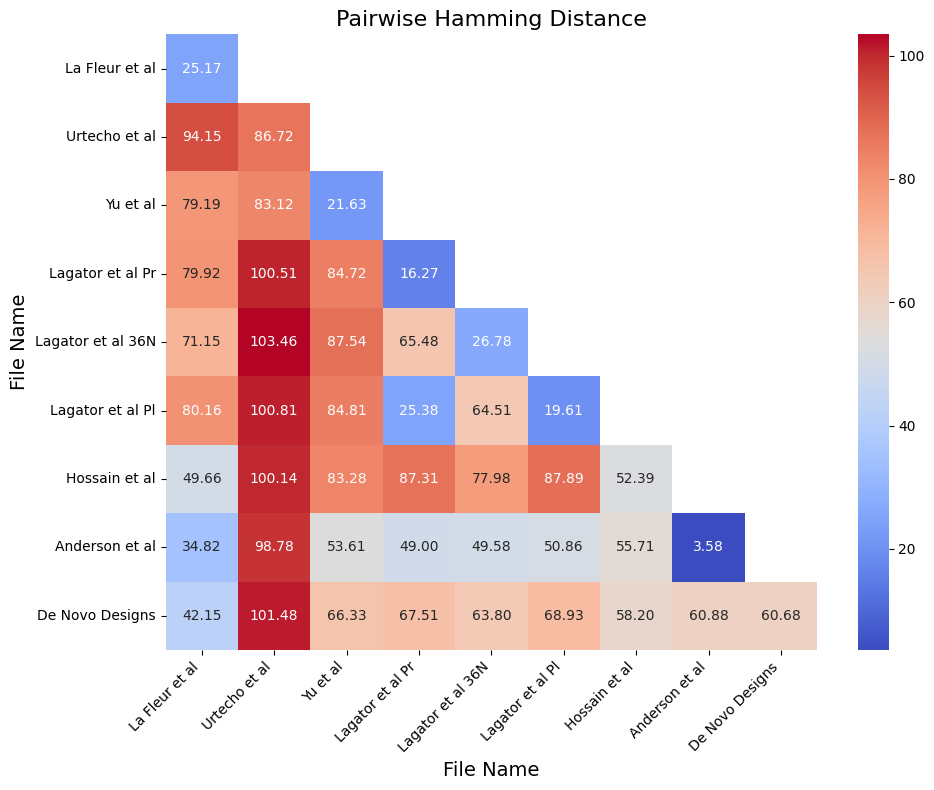

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pairwise_distances = pd.read_csv('Data/pairwise_file_distance.csv', index_col=0)
mask = np.triu(np.ones(pairwise_distances.shape), k=1)

plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_distances, 
            cmap='coolwarm', 
            annot=True, 
            fmt=".2f", 
            mask=mask, 
            xticklabels=pairwise_distances.columns, 
            yticklabels=pairwise_distances.index)

plt.title('Pairwise Hamming Distance', fontsize=16)
plt.xlabel('File Name', fontsize=14)
plt.ylabel('File Name', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save the figure
plt.savefig('Figures/FigureS2.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Figure S3
-----

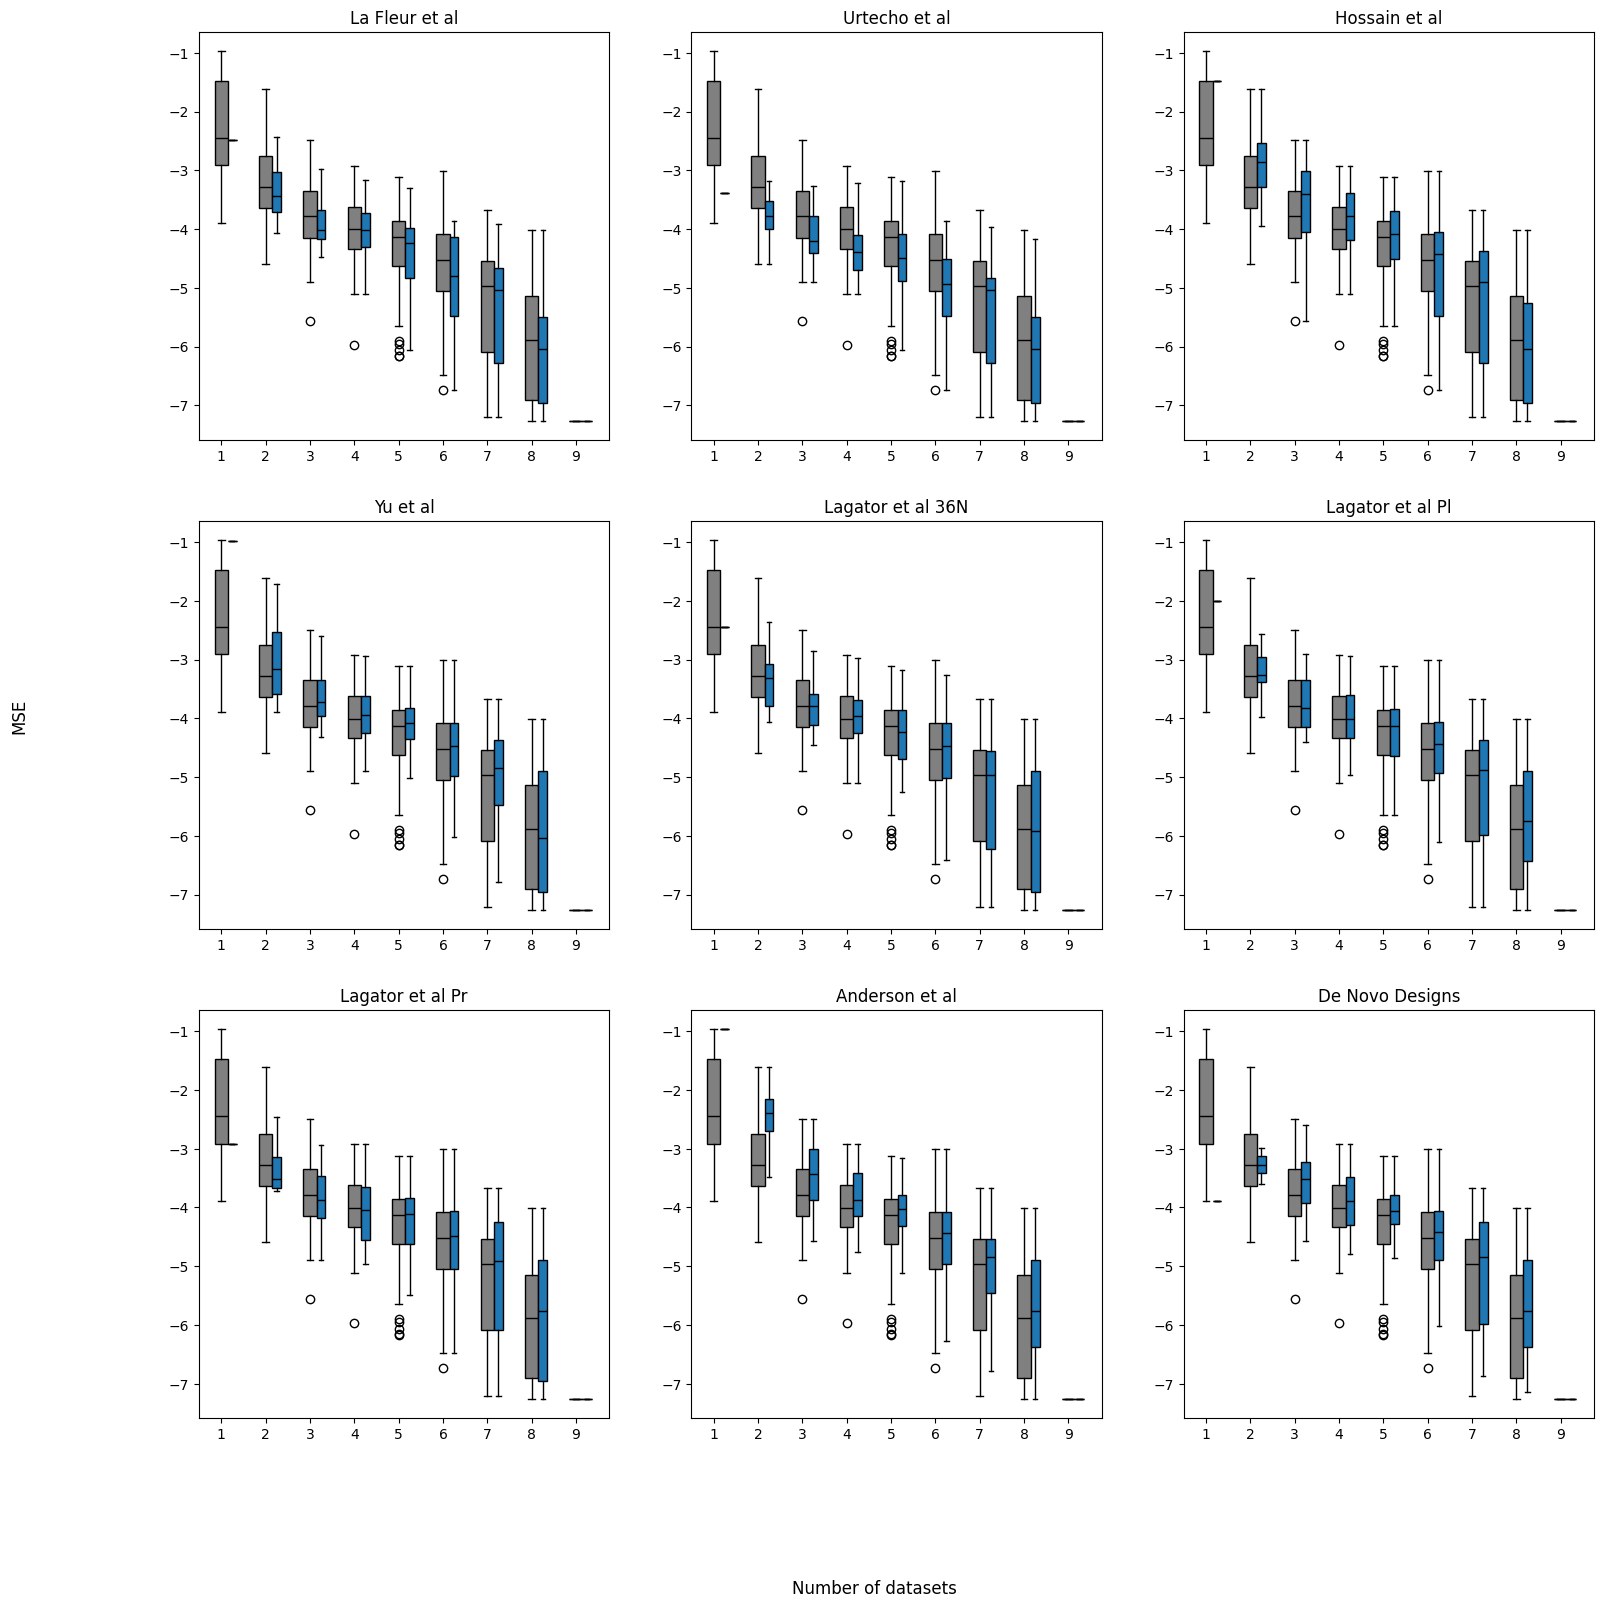

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
file_names = pd.read_csv('Data/LaFleur_supp.csv')['File Name'].unique()

data_df = pd.read_csv('Data/data_comparison.csv')
data = data_df[['Number of Files', 'MSE', 'Name']].values

x_all = sorted(set(int(n) for n, _, _ in data))

fig, axs = plt.subplots(3, 3, figsize=(18, 18))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i, file_name in enumerate(file_names):
    row, col = divmod(i, 3)
    ax = axs[row, col]
    
    ax.set_title(file_name)
    for x in x_all:
        y_vals = [l for n, l, combo in data if int(n) == x]
        ax.boxplot([y_vals], positions=[x], widths=0.3, patch_artist=True,
                    boxprops=dict(facecolor='grey'),
                    medianprops=dict(color='black'))
        y_vals = [mse for n, mse, combo in data if int(n) == x and file_name in str(combo)]
        
        # Offset x slightly for visual separation
        offset = 0.25
        ax.boxplot([y_vals], positions=[x + offset], 
                   widths=0.2, patch_artist=True, showfliers=False,
                   medianprops=dict(color='black'))
    ax.set_xticks(x_all, labels=[str(i) for i in x_all])
fig.supxlabel("Number of datasets")
fig.supylabel("MSE")

fig.savefig('Figures/FigureS3.pdf', dpi=300, bbox_inches='tight')


## TableS1-

-----